# Project 2: Advanced Lane Finding
---
## Imports

In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

## Step 0: Helper-Functions

In [2]:
def side_by_side(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Camera Calibration & Undistortion

In [3]:
def cal_camera(nx, ny, cal_images_path, reference_image):

    # Gather all images at this path
    images = glob.glob(cal_images_path)

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points -> real world
    imgpoints = [] # 2D points -> image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8, 5, 0)
    objp = np.zeros((ny * nx,3), np.float32) # Creating 6*9 points, each of dimension 3, initialized all with zeros
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # fill coordinate points (the z coordinate will stay zero, so we just grid and 'iterate in' the points (0,0,0) to (8, 5, 0) here)

    # Reshape shapes the grid back into two columns, one for x, and one for y
    for fname in images:
        img = cv2.imread(fname)
    
        # Convert image to grayscale (a copy of it that is)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # Getting OpenCV to search and find edge points
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        # If edge points were found, connect them one after the other
        if ret == True:
            imgpoints.append(corners)   # actual coordinates of reshaped image
            objpoints.append(objp)      # coordinates representing reality, used with imgpoints to calibrate camera
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)

    # Write the findings into a file for more light-weight interaction later on
    cal_pickle = {}
    cal_pickle["mtx"] = mtx
    cal_pickle["dist"] = dist
    pickle.dump(cal_pickle, open("./calibration_pickle.p", "wb"))


def cal_undistort(img):
    
    cal_pickle = pickle.load(open("./calibration_pickle.p", "rb"))
    mtx = cal_pickle["mtx"]
    dist = cal_pickle["dist"]
    
    # Undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

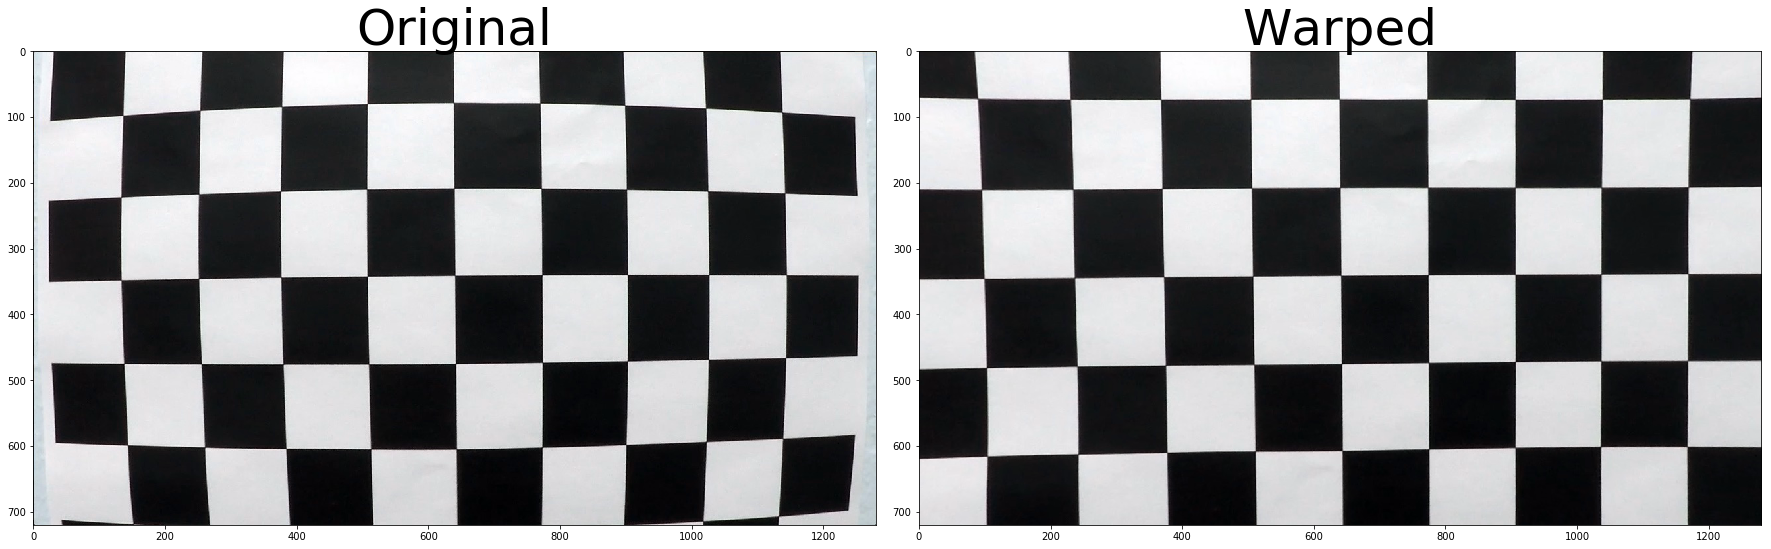

In [4]:
cal_camera(9, 6, './camera_cal/calibration*.jpg', './test_images/test1.jpg')

# Just to show the now achieved undistortion effect
cal_img = cv2.imread('./camera_cal/calibration1.jpg')
cal_undistorted = cal_undistort(cal_img)

side_by_side(cal_img, cal_undistorted, 'Original', 'Warped')

## Experimenting: Image correction

---

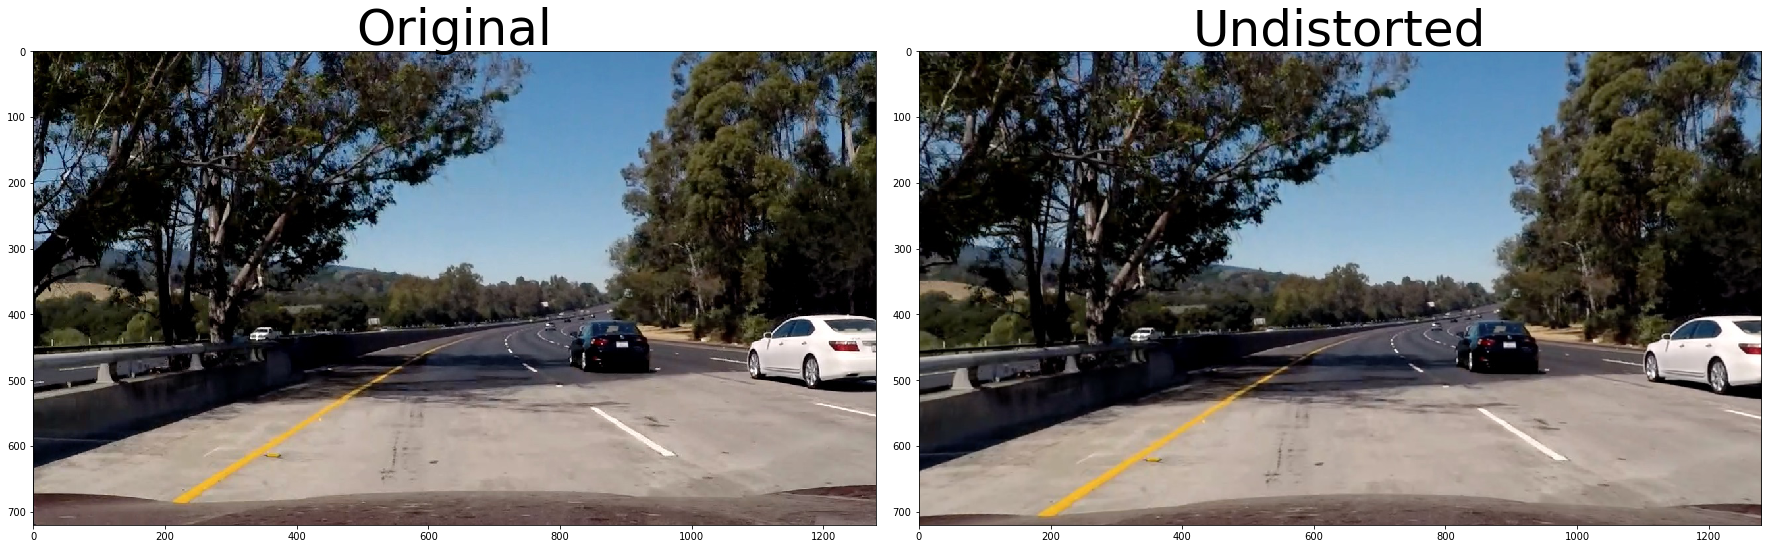

In [5]:
# Chosen image imo best captures possible fluctuations in lighting
exp_img = mpimg.imread('./test_images/test5.jpg')

# Undistort
undist_img = cal_undistort(exp_img)
side_by_side(exp_img, undist_img, 'Original', 'Undistorted')

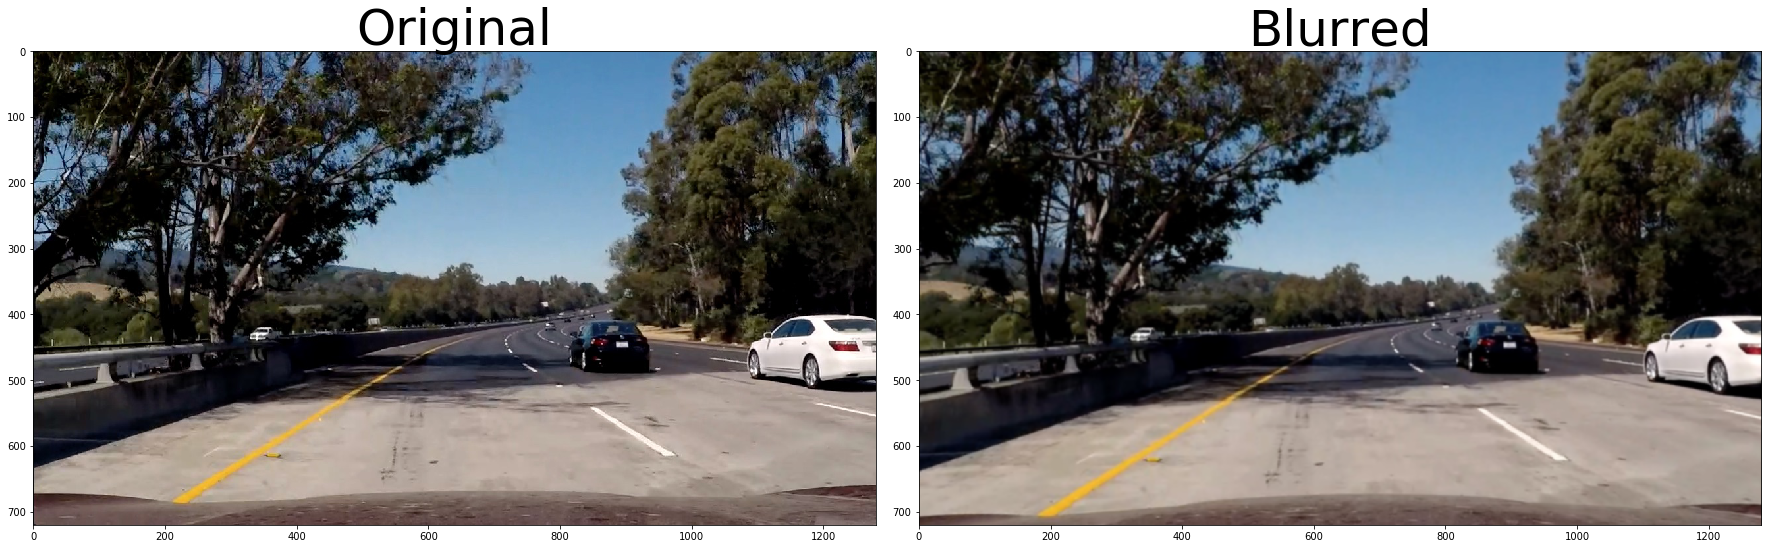

In [6]:
# Blur
# Reduces amount of pixels falsely identified as being part of an edge of interest
blur_img = cv2.GaussianBlur(undist_img, (5,5), 0)
side_by_side(exp_img, blur_img, 'Original', 'Blurred')

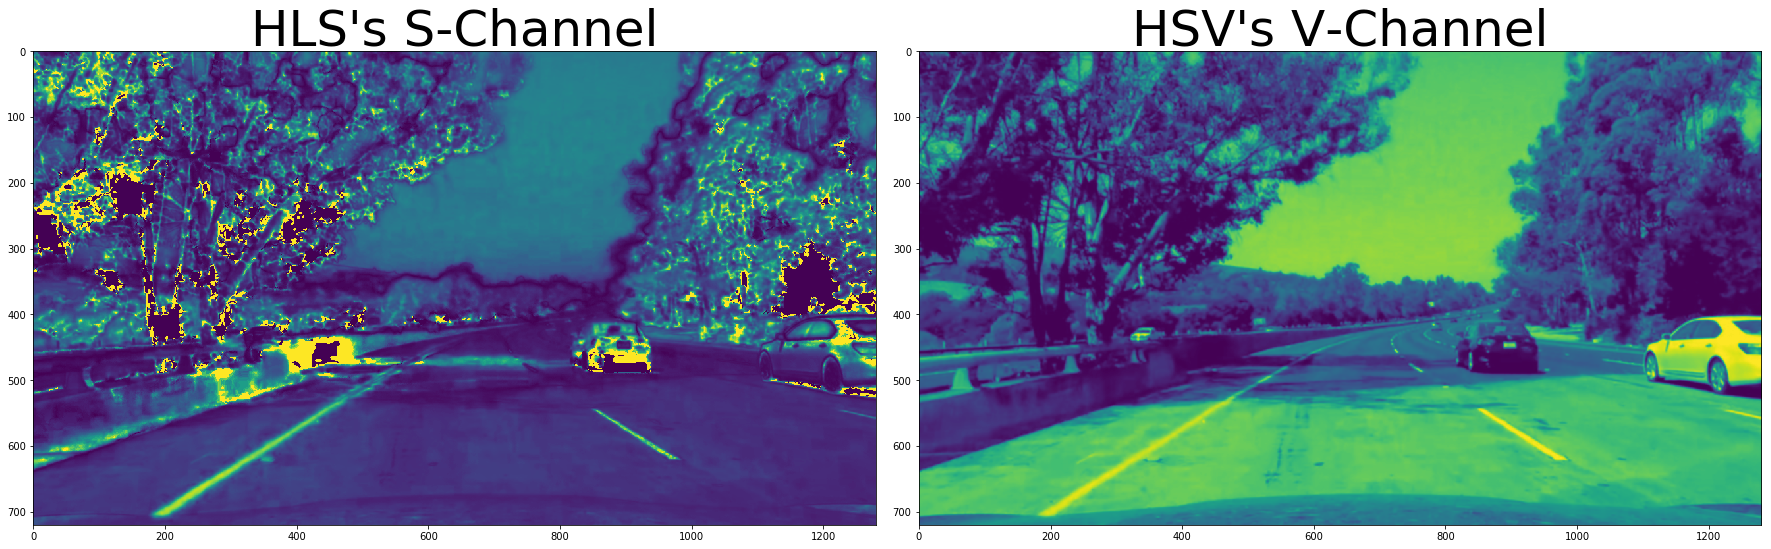

In [7]:
# HLS's S_Channel
s_channel = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HLS)[:,:,2]

# HSV's V_Channel
v_channel = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)[:,:,2]

side_by_side(s_channel, v_channel, 'HLS\'s S-Channel', 'HSV\'s V-Channel')

### Thresholding steps

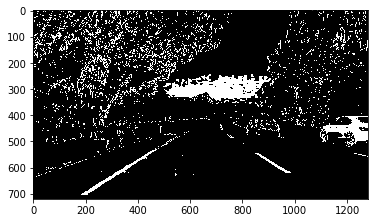

In [8]:
s_thresh = (180, 200)
sobel_x_thresh = (40, 100)
v_thresh = (210, 255)

sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) 
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

all_binary = np.zeros_like(s_channel)
all_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) | 
              (v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1]) |
              (scaled_sobel >= sobel_x_thresh[0]) & (scaled_sobel <= sobel_x_thresh[1])] = 1

plt.imshow(all_binary, cmap='gray')

### Region Masking

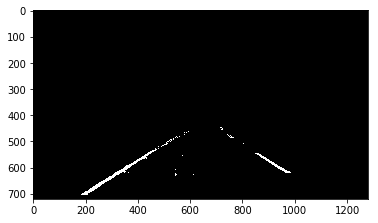

In [9]:
# Find region of interest
sides = np.array([[140, all_binary.shape[0]],             # lower left
                  [625, all_binary.shape[0]*0.6],         # upper left
                  [700, all_binary.shape[0]*0.6],         # upper right
                  [1200, all_binary.shape[0]]], np.int32) # lower right

mask = np.zeros_like(all_binary)   
include_mask_color = (255, 255, 255)

cv2.fillPoly(mask, np.int32([sides]), include_mask_color)
region_image = cv2.bitwise_and(all_binary, mask)

plt.imshow(region_image, cmap="gray")

### Perspective Transform: Finding Image Points

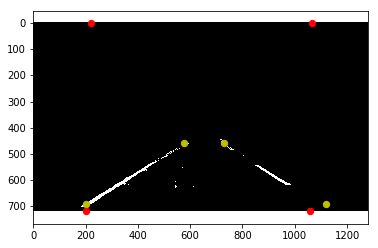

In [10]:
x_in = [575, 200, 1120, 730]
y_in = [460, 690, 690, 460]

x_out = [220, 200, 1060, 1065]
y_out = [0, 720, 720, 0]

plt.imshow(region_image, cmap="gray")
plt.scatter(x_in, y_in, c='y', s=40)
plt.scatter(x_out, y_out, c='r', s=40)

### Perspective Transform: Turning Into A Bird

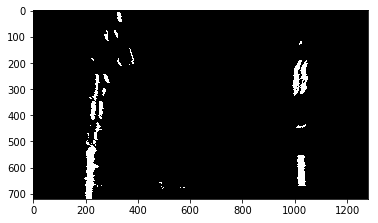

In [11]:
src = np.float32([[x_in[0],y_in[0]],[x_in[1],y_in[1]],[x_in[2],y_in[2]],[x_in[3],y_in[3]]])
dst = np.float32([[x_out[0],y_out[0]],[x_out[1],y_out[1]],[x_out[2],y_out[2]],[x_out[3],y_out[3]]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_img = cv2.warpPerspective(region_image, M, (exp_img.shape[1], exp_img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped_img, cmap="gray")

### Bringing it all together: Functions of a pipeline

In [12]:
# Apply the Gaussian Blur filter 
def blur(img, kernel_size=(5,5)):
    # this reduces the amount of 'falsely positive' edge pixels detected later on
    return cv2.GaussianBlur(img, kernel_size, 0)


# Color-optimizing and detecting edges in given image
def get_binary(img, s_thresh=(180, 200), sobel_x_thresh=(40, 100), v_thresh=(210, 255)):
    copy = np.copy(img)

    # HLS's saturation channel (looked promising in the experiments)
    s_channel = cv2.cvtColor(copy, cv2.COLOR_BGR2HLS)[:, :, 2]

    # HSV's value channel (looked promising aswell)
    v_channel = cv2.cvtColor(copy, cv2.COLOR_BGR2HSV)[:, :, 2]

    # Edge detection done on the v_channel
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Combining all pixels of interest from sobel and the color-channels to form a binary mask
    all_binary = np.zeros_like(s_channel)
    all_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) |
               (v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1]) |
               (scaled_sobel >= sobel_x_thresh[0]) & (scaled_sobel <= sobel_x_thresh[1])] = 1

    return all_binary


# Limiting image's contents to only the white pixels enclosed by 'sides'
def region_mask(img, sides):
    
    # Starting with a blank mask
    mask = np.zeros_like(img)   
    
    include_mask_color = (255, 255, 255)
        
    # Coloring those pixels of 'mask' that are enclosed by 'sides' with the fill color
    cv2.fillPoly(mask, np.int32([sides]), include_mask_color)
    
    # A new image now only holds those pixels that are white in both 'mask' and 'img'
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Warp the image to bird's eye view using hard-coded values from experiments
def birds_eye(img):
    
    # Hard-coded, found through experimenting
    x_in = [575, 200, 1120, 730]
    y_in = [460, 690, 690, 460]

    x_out = [220, 200, 1060, 1065]
    y_out = [0, 720, 720, 0]
    
    src = np.float32([[x_in[0],y_in[0]],[x_in[1],y_in[1]],[x_in[2],y_in[2]],[x_in[3],y_in[3]]])
    dst = np.float32([[x_out[0],y_out[0]],[x_out[1],y_out[1]],[x_out[2],y_out[2]],[x_out[3],y_out[3]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    transformed_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # Returing both the birdified image and the Matrix to reverse the applied warping
    return Minv, transformed_img
    
    
# interconnecting pixel clusters that form a line
def find_lanes(img, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ym_per_pixel = 30/720 
    xm_per_pixel = 3.7/700 
    
    left_fit_m = np.polyfit(lefty*ym_per_pixel, leftx*xm_per_pixel, 2)
    right_fit_m = np.polyfit(righty*ym_per_pixel, rightx*xm_per_pixel, 2)
    
    radius, offset = get_radius_and_offset(left_fit_m, right_fit_m, ym_per_pixel, xm_per_pixel)

    # Highlight lane pixels and draw fit polynomials
    lane_pixel_img = np.dstack((img, img, img))*255
    lane_pixel_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    lane_pixel_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, lefty, rightx, righty, radius, offset, out_img


# Drawing a given polynomial into an image
def draw_polynomial(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0]*y**2 + fit[1]*y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255, 255,0), thickness=5)

    
# Searching for lanes and returning both function fits aswell as radius and offset
def fit_polynomials(img):    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, radius, offset, out_img = find_lanes(img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    draw_polynomial(out_img, left_fit)
    draw_polynomial(out_img, right_fit)
    
    return ploty, left_fit, right_fit, out_img, radius, offset


# Coloring the space enclosed by left_fit and right_fit green
def draw(img, warped_binary, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warped = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped_binary.shape[0] - 1, warped_binary.shape[0])
    leftx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    rightx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warped, np.int_([pts]), (0, 255, 0))
    return color_warped


# Undoing the warping applied to better see curves so that the image looks as it was before again
def undo_birds_eye(color_warp, img, Minv):
    color_unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, color_unwarped, 0.25, 0)
    return result


# Calculating the radius in meters for both fitted functions
# Radius is mean of radius of both lanes
# Offset indicates how far camera is away from center
def get_radius_and_offset(left_fit, right_fit, y_m_pixel, x_m_pixel):
    l_poly_radius = ((1 + (2 * left_fit[0] * 720 * y_m_pixel + left_fit[1]) ** 2) ** (3 / 2)) / np.abs(2 * left_fit[0])
    r_poly_radius = ((1 + (2 * right_fit[0] * 720 * y_m_pixel + right_fit[1]) ** 2) ** (3 / 2)) / np.abs(2 * right_fit[0])

    left_lane = left_fit[0] * (720 * y_m_pixel) ** 2 + left_fit[1] * 720 * y_m_pixel + left_fit[2]
    right_lane = right_fit[0] * (720 * y_m_pixel) ** 2 + right_fit[1] * 720 * y_m_pixel + right_fit[2]

    radius = np.mean([l_poly_radius, r_poly_radius])
    offset = [640 * x_m_pixel - np.mean([left_lane, right_lane]), right_lane - left_lane]
    return radius, offset


# Writing the Radius and Offset values on the image
def write_text(rewarped_img, radius, offset):
    # This helped me: 
    # https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2
    cv2.putText(rewarped_img, 'Radius: {}m'.format(round(radius)), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 255, 255), 4)
    cv2.putText(rewarped_img, 'Offset: {}m'.format(round(offset[0], 4)), (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 255, 255), 4)
    return rewarped_img

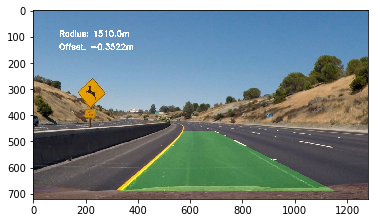

In [13]:
# Directories for test image input and output
input_dir = "test_images/"
output_dir = "output_images/"

img_set = os.listdir(input_dir)

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Repeat for every found image
for img_name in img_set:
    img = cv2.imread(input_dir + img_name)
    img_copy = np.copy(img)

    undist_img = cal_undistort(img_copy)
    blur_img = blur(undist_img)
    all_binary = get_binary(blur_img)

    sides = np.array([[140,  all_binary.shape[0]],             # lower left
                      [625,  all_binary.shape[0]*0.6],         # upper left
                      [700,  all_binary.shape[0]*0.6],         # upper right
                      [1200, all_binary.shape[0]]], np.int32)  # lower right

    region_img = region_mask(all_binary, [sides])
    Minv, warped_binary = birds_eye(region_img)

    ploty, left_fit, right_fit, polyfit_img, radius, offset = fit_polynomials(warped_binary)

    color_warped = draw(img_copy, warped_binary, left_fit, right_fit, Minv)
    lanes_img = undo_birds_eye(color_warped, img_copy, Minv)

    result_img = write_text(lanes_img, radius, offset)
    
    # Save current image to given output directory
    cv2.imwrite(output_dir + img_name, result_img)
    
    # Show the last processed image
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))

## Applying the pipeline to a video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
# These variables will later be used for smoothing lane detection across multiple frames
last_n_frames_radius = []
last_n_frames_offset = []
last_frame_left_fit = {}
last_frame_right_fit = {}

In [21]:
def frame_pipeline(img):
    
    # Always always work on a copy
    img_copy = np.copy(img)

    # remove camera-based distortion, blur to rule out some 'false' edge pixels, 
    # create a binary mask optimized to show lanes
    undist_img = cal_undistort(img_copy)
    blur_img = blur(undist_img)
    all_binary = get_binary(blur_img)

    # hard-coded sides within which lanes are expected to be
    sides = np.array([[140,  all_binary.shape[0]],             # lower left
                      [625,  all_binary.shape[0]*0.6],         # upper left
                      [700,  all_binary.shape[0]*0.6],         # upper right
                      [1200, all_binary.shape[0]]], np.int32)  # lower right

    # create mask consisting of previously created 'all_binary' reduced to area enclosed by 'sides'
    region_img = region_mask(all_binary, [sides])
    # warp this area-focused mask into a bird's eye view to better detect curves
    Minv, warped_binary = birds_eye(region_img)

    # find polynomials, radius and offset for the lanes found in bird's eye view
    ploty, left_fit, right_fit, polyfit_img, radius, offset = fit_polynomials(warped_binary)

    # smooth out radius and offset and reduce amount of hectic changes to left_fit and right_fit
    radius, offset, left_fit, right_fit = average_over_frames(radius, offset, left_fit, right_fit, 10, 10)
    
    # paint the area in the image that the car judges to be ideal to drive in
    color_warped = draw(img_copy, warped_binary, left_fit, right_fit, Minv)
    lanes_img = undo_birds_eye(color_warped, img_copy, Minv)

    # add written information to detail what the pipleline does and how it reacts to measurements
    result_img = write_text(lanes_img, radius, offset)
    return result_img


# Averages over n frames and additionally checks whether from frame to frame the radius jumps over p amount
def average_over_frames(radius, offset, left_fit, right_fit, n, p):
    
    global last_n_frames_radius
    global last_n_frames_offset
    global last_frame_left_fit
    global last_frame_right_fit
    
    # fill and then keep a list of n most recent radius measurements to average over
    if len(last_n_frames_radius) >= n:
        last_n_frames_radius.append(radius)
        last_n_frames_radius.pop(0)
    else:
        last_n_frames_radius.append(0)
        
    # fill and then keep a list of n most recent offset measurements to average over
    if len(last_n_frames_offset) >= n:
        last_n_frames_offset.append(offset[0])
        last_n_frames_offset.pop(0)
    else:
        last_n_frames_offset.append(0)
    
    # average over the last n elements of the radius-list and the offset-list
    avg_radius = sum(last_n_frames_radius) / len(last_n_frames_radius)
    avg_offset = offset
    avg_offset[0] = sum(last_n_frames_offset) / len(last_n_frames_offset)
    
    # if there is no left_fit or right_fit recorded already, record it
    if len(last_frame_left_fit) == 0 or len(last_frame_right_fit) == 0:
        last_frame_left_fit = left_fit
        last_frame_right_fit = right_fit
    
    # if the radius changes with a rate p compared to the most recent radius measurement
    # something might be wrong, the last left_fit and right_fit should be kept
    return avg_radius, avg_offset, left_fit, right_fit

In [22]:
video_input  = './project_video.mp4' 
video_output = 'output_video/project_video.mp4'

clip1 = VideoFileClip(video_input)
white_clip = clip1.fl_image(frame_pipeline)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 2min 22s, sys: 19.6 s, total: 2min 42s
Wall time: 4min 53s


In [23]:
HTML("""
    <video width="960" height="540" alt="project_video" controls>
        <source src="output_video/project_video.mp4" type="video/mp4">
    </video>
""")